# Basil Docking V0.1 - Data Manipulation and Collection
## Purpose

__Target Audience__<br>
Undergraduate chemistry/biochemistry students and, in general, people that have little to no knowledge of protein-ligand docking and would like to understand the general process of docking a ligand to a protein receptor.

__Brief Overview__<br>
Molecular docking is a computational method used to predict where molecules are able to bind to a protein receptor and what interactions exist between the molecule (from now on, refered to as "ligand") and the receptor. It is a popular technique utilized in drug discovery and design, as when creating new drugs and testing existing drugs aginst new receptors, it is useful to determine the likelihood of binding prior to screening as it can be used to eliminate molecules that are unlikely to bind to the receptor. This significantly reduces the potential cost and time needed to test the efficacy of a set of possible ligands. <br>

The general steps to perform molecular docking, assuming the ligand and receptor are ready to be docked, include the generation of potential ligand binding poses and the scoring of each generated pose (which predicts how strongly the ligand binds to the receptor, with a more negative score corresponding to a stronger bond). To dock a ligand to a protein, (insert text).<br>

This notebook series encompasses 
1. the preparation needed prior to docking (protein and ligand sanitation, ensuring files are in readable formats, and finding possible binding pockets)
2. the process of docking ligand/s to a protein receptor using two docking engines (VINA and SMINA) and visualizing/analyzing the outputs
3. __further data collection and manipulation__
4. utilizing machine learning to determine key residues (on the protein) and functional groups (on the ligand) responsible for protein-ligand binding

__Stepwise summary for this notebook (docking data manipulation and collection, notebook 3 out of (number))__
- create derivatives for ligands by substituting/modifying functional groups on canonical ligand
- dock derivative/s to receptor
- collect and store data including but not limited to the score, interaction type, distance between interacting atoms from the ligand and protein, and functional group involved in interaction


To do:
- stuff denoted by comments in various cells
- in general, fix and make more efficient

## Table of Libraries Used
### Operations, variable creation, and variable manipulation

| Module (Submodule/s) | Abbreviation| Role | Citation |
| :--- | :--- | :--- | :--- |
| numpy | np | add description | Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). DOI: 10.1038/s41586-020-2649-2. (Publisher link). |
| pandas | pd | addescription | add source |
| regex | re | add description |  add source |
| os | n/a | add description |  add source |
| sys | n/a | add description |  add source |
|glob | n/a | add description | add source |

### Protein and Ligand Preparation
| Module (Submodule/s)| Abbreviation | Role | Citation |
| :--- | :--- | :--- | :--- |
| open babel (pybel)| n/a | hygrogenates ligands and prepares ligands for docking |  O'Boyle, N.M., Banck, M., James, C.A. et al. Open Babel: An open chemical toolbox. J Cheminform 3, 33 (2011). https://doi.org/10.1186/1758-2946-3-33.|
| rdkit (Chem)| n/a | ligand creation and sanitation |  RDKit: Open-source cheminformatics; http://www.rdkit.org |

### Visualization
| Module (Submodule/s)| Abbreviation | Role | Citation |
| :--- | :--- | :--- | :--- |
| rdkit.Chem (AllChem, Draw)| n/a | ligand visualization |  RDKit: Open-source cheminformatics; http://www.rdkit.org |
| py3Dmol | n/a | apoprotein and protein complex visualization |  Keshavan Seshadri, Peng Liu, and David Ryan Koes. Journal of Chemical Education 2020 97 (10), 3872-3876. https://doi.org/10.1021/acs.jchemed.0c00579. |

### Docking
| Module (Submodule/s)| Abbreviation | Role | Citation |
| :--- | :--- | :--- | :--- |
| vina | n/a | ligand-protein docking |  Eberhardt, J., Santos-Martins, D., Tillack, A.F., Forli, S. (2021). AutoDock Vina 1.2.0: New Docking Methods, Expanded Force Field, and Python Bindings. Journal of Chemical Information and Modeling. |
| --- | --- | --- | Trott, O., & Olson, A. J. (2010). AutoDock Vina: improving the speed and accuracy of docking with a new scoring function, efficient optimization, and multithreading. Journal of computational chemistry, 31(2), 455-461. |
| smina | n/a | ligand-protein docking |  Koes, D. R., Baumgartner, M. P., & Camacho, C. J. (2013). Lessons learned in empirical scoring with smina from the CSAR 2011 benchmarking exercise. Journal of chemical information and modeling, 53(8), 1893–1904. https://doi.org/10.1021/ci300604z |

### Data analysis
| Module (Submodule/s)| Abbreviation | Role | Citation |
| :--- | :--- | :--- | :--- |
| MDAnalysis | mda | add description | R. J. Gowers, M. Linke, J. Barnoud, T. J. E. Reddy, M. N. Melo, S. L. Seyler, D. L. Dotson, J. Domanski, S. Buchoux, I. M. Kenney, and O. Beckstein. MDAnalysis: A Python package for the rapid analysis of molecular dynamics simulations. In S. Benthall and S. Rostrup, editors, Proceedings of the 15th Python in Science Conference, pages 98-105, Austin, TX, 2016. SciPy, doi:10.25080/majora-629e541a-00e. |
| --- | --- | --- | N. Michaud-Agrawal, E. J. Denning, T. B. Woolf, and O. Beckstein. MDAnalysis: A Toolkit for the Analysis of Molecular Dynamics Simulations. J. Comput. Chem. 32 (2011), 2319-2327, doi:10.1002/jcc.21787. PMCID:PMC3144279. |
| prolif (Complex3D)| plf | add description|  chemosim-lab/ProLIF: v0.3.3 - 2021-06-11.https://doi.org/10.5281/zenodo.4386984. |


In [3]:
import numpy as np
import pandas as pd
import re
import sys, os
import glob
sys.path.insert(1, 'utilities/')
from utils import pdbqt_to_sdf
import ipywidgets as widgets
from ipywidgets import Layout, Label, Dropdown, Box, SelectMultiple

from openbabel import pybel
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

import prolif as plf
from prolif.plotting.complex3d import Complex3D
import MDAnalysis as mda 
from MDAnalysis.coordinates import PDB

## Import Values from docking-and-prelim-analysis

Prior to docking, the data obtained from the previous notebook needs to be imported in order to be used. The glob library gets the pdb file containing the receptor, and the ligand information is obtained from the ligand_information.csv file created at the end of the previous notebook. The protein pocket information generated from fpocket is imported from the prot_pockets.csv file.

In [4]:
# get needed values 
prot_pockets = pd.read_csv('data/protein_pockets.csv',index_col=[0])
ligand_information = pd.read_csv('data/ligand_information.csv')

find_pdb = os.path.join('data', 'PDB_files', '*.ent')
prot_file = glob.glob(find_pdb)[0]
prot_file_split = prot_file.split('/')[-1]
pdb_id = prot_file_split[3:7]

In [5]:
ligs = []
filenames = []
filenames_H = []
filenames_pdbqt = []
for r in ligand_information.index:
    ligs.append(ligand_information["ligs"][r])
    filenames.append(ligand_information["filenames"][r])
    filenames_H.append(ligand_information["filenames_H"][r])
    filenames_pdbqt.append(ligand_information["filenames_pdbqt"][r])

## Data manipulation and collection

### Analyze functional groups in each ligand and create derivatives

To create modified ligands to dock against the receptor, the functional groups of the original ligand/s are identified using substructure matching of SMILES and SMARTS strings pertaining to different functional groups. The names of each functional group present in the original ligand are saved along with the indexes of the atoms in the ligand making up the functional group. The result is a list of ones and zeros called `all_func_groups`, where a "1" corresponds to a functional group being present and a "0" corresponds to a functional group being absent. If the functional groups of multiple ligands are being idendified, `all_func_groups` will be a nested list containing the results for each ligand.

In [23]:
all_func_groups = [] 

#common functional groups
ester = '[CX3H1,CX3](=O)[OX2H0][C;!$([C]=[O])]'
ether = '[OD2]([C;!$([C]=[O])])[C;!$([C]=[O])]'
hydroxy = '[OX2H;$([O]([C])[H]);!$([O](C=O)[H])][H]'
carbox_acid = '[CX3;!$([CX3][H])](=O)[OX2H][H]'
aldehyde = '[CX3;$(C([H])(=O)[C])](=[O;!$([O][O])])[H]'
anhydr = 'C-[CX3](=O)[O][CX3](=O)-C'

#nitrogen containing
amine = '[C][NX3;H2;!$(NC=O)]([H])[H]'
amine_2 = '[C][NX3;H;!$(NC=O)]([C])[H]'
amine_3 = '[C][NX3;H0;!$(NC=O);!$(N=O)]([CX4])[CX4]'
amide = '[CX3](=O)[NX3;!$(N=O)]([H])[H]' 
amide_2 = '[CX3](=O)[NX3;!$(N=O)]([C])[H]'
amide_3 = '[CX3](=O)[NX3;!$(N=O)]([C])[C]'
nitro = 'C-N(=O)-O'
imine = '[C;$(C([C,H])([C,H])=[N])]=[N][C,H]'

#halogens
f_hal = 'F'
cl_hal = 'Cl'
br_hal = 'Br'
i_hal = 'I'

#multiply bonded and rings
alkene = 'C=C'
alkyne = 'C#C'
alkyne_term = 'C#C-[H]'
phenyl = '[CX4;$([C][c;$(c1cc[c]cc1)]);!$([C]([H])([H])([C])[c;$(c1cc[c]cc1)])][c]1:[c]:[c]:[c]:[c]:[c]1'
benzyl = '[CX4;$([C](c1ccccc1)([H])([H])[C])][c]1:[c]:[c]:[c]:[c]:[c]1'
pyrrole = '[$([NH]1C=CC=C1)]'
imidiz = '[$([NH]1C=NC=C1)]'
pyridine = '[$([nR1]1[cR1][cR1][cR1][cR1][cR1]1)]'
pyrimidine = '[$([nR1]1[cR1][nR1][cR1][cR1][cR1]1)]'

functional_groups = [ester, ether, hydroxy, carbox_acid, aldehyde, anhydr, amine, amine_2, amine_3, 
                     amide, amide_2, amide_3, nitro, imine, f_hal, cl_hal, br_hal, i_hal, alkene, 
                     alkyne, alkyne_term, phenyl, benzyl, pyrrole, imidiz, pyridine, pyrimidine]

functional_groups_dict = {
    ester : 'ester',
    ether : 'ether',
    hydroxy : 'hydroxy',
    carbox_acid : 'carbox_acid',
    aldehyde :'aldehyde',
    anhydr : 'anhydr',
    amine : 'amine',
    amine_2 : 'amine_2',
    amine_3: 'amine_3',
    amide : 'amide',
    amide_2 : 'amide_2',
    amide_3: 'amide_3',
    nitro : 'nitro',
    imine: 'imine',
    f_hal :'f_hal',
    cl_hal : 'cl_hal',
    br_hal : 'br_hal',
    i_hal : 'i_hal',
    alkene : 'alkene',
    alkyne : 'alkyne',
    alkyne_term : 'alkyne_term',
    phenyl : 'phenyl',
    benzyl : 'benzyl',
    pyrrole : 'pyrrole',
    imidiz : 'imidiz',
    pyridine : 'pyridine',
    pyrimidine : 'pyrimidine'
}
    
for i in ligs:
    mol_groups = []
    mol = Chem.MolFromMol2File(f"data/MOL2_files/{i}_H.mol2", sanitize = False)
    for j in functional_groups:
        k = Chem.MolFromSmarts(j)
        if mol.HasSubstructMatch(k):
            mol_groups.append(1) # 1 corresponds to a functional group being present
            print(f'Atom indices for substructure match (type: {functional_groups_dict[j]}) in ligand {i}: ')
            idxes = mol.GetSubstructMatches(k)
            idxes_list = list(idxes)
            print(idxes)
        else:
            mol_groups.append(0) # 0 corresponds to a functional group being absent
    all_func_groups.append(mol_groups)

Atom indices for substructure match (type: ether) in ligand FAD606: 
((6, 5, 11),)
Atom indices for substructure match (type: hydroxy) in ligand FAD606: 
((8, 58), (10, 60), (42, 80), (44, 82), (46, 84))
Atom indices for substructure match (type: alkene) in ligand FAD606: 
((32, 34), (36, 37))
Atom indices for substructure match (type: ether) in ligand MTE1326: 
((17, 8, 16),)
Atom indices for substructure match (type: amine) in ligand MTE1326: 
((1, 2, 24, 25),)
Atom indices for substructure match (type: amine_2) in ligand MTE1326: 
((7, 6, 10, 27), (8, 9, 11, 30))
Atom indices for substructure match (type: amide_2) in ligand MTE1326: 
((4, 5, 3, 1, 26),)
Atom indices for substructure match (type: alkene) in ligand MTE1326: 
((12, 14),)


[20:57:17] FES601: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[20:57:17] FES602: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


Derivatives of each original ligand will be created by replacing one of its identified functional groups with a different functional group. To reduce the number of small ligands created due to fragmentation, ligands with a SMILES string containing less than 25 characters will be ignored and will not be used for docking. If there are any inconsistancies within the derived ligand (i.e. atoms marked as aromatic that shouldn't be, atoms not following traditional binding rules) the derived ligand will be ignored and will not be used for docking.

In [24]:
derivative_mols = []
derivative_smile = []

groups_dict = {
    'ester': ['C(=O)-[NH]-C', 'C[C](=O)[O][C](=O)C'],
    'ether': ['C-S-C'],
    'hydroxy': ['C(=O)[OH]', 'C(=O)[H]', 'C(=O)-Cl'],
    'carbox_acid': ['C(=O)-[H]', 'C(=O)-Cl'],
    'aldehyde': ['C(=O)[OH]', 'C(=O)-Cl', 'C-[OH]', 'C-S-[H]', 'C(=[NH])[H]'],
    'anhydr': ['C(=O)-[NH]-C','C(=O)OC', 'C(=O)-[NH]-C'],
    'amine': ['CC', 'C-[N+](=O)-[O-]'],
    'amide': ['C(=O)[OH]', 'C(=O)[H]'],
    'amide_2': ['C(=O)OC'],
    'nitro': ['C-[NH2]'],
    'f_hal': ['Cl', 'Br', 'I'],
    'cl_hal': ['F', 'Br', 'I'],
    'br_hal': ['F', 'Cl', 'I'],
    'i_hal': ['F', 'Cl', 'Br'],
    'alkyne_term': ['C#N'], 
    'phenyl' : ['Cc1ccc([OH])cc1','Cc1ccc(OC)cc1', 'Cc1ccc(C)cc1', 'Cc1ccccc1'],
    'benzyl': ['CCc1ccc([OH])cc1','CCc1ccc(OC)cc1', 'CCc1ccc(C)cc1', 'CCc1ccccc1'],
    'pyrrole': ['[NH]1C=NC=C1'],
    'imidiz': ['[NH]1C=CC=C1'],
    'pyridine': ['n1cnccc1'],
    'pyrimidine': ['n1ccccc1']
}
#clean up
def derive(ligand, group):
    mol = Chem.MolFromMol2File(f"data/MOL2_files/{ligand}_H.mol2",sanitize=False)
    old_substr = Chem.MolFromSmarts(group)
    if functional_groups_dict[group] in groups_dict:
        replacement_values = groups_dict[functional_groups_dict[group]]
        for a in replacement_values:
            if a != group:
                new_substr = Chem.MolFromSmiles(a)
                rms = AllChem.ReplaceSubstructs(mol, old_substr, new_substr)
                fragments = Chem.GetMolFrags(rms[0])
                for frag in fragments:
                    ind_frag = Chem.MolFragmentToSmiles(rms[0], frag)
                    if (len(ind_frag) > 25) & (ind_frag != "O[H][H]") & (ind_frag not in derivative_smile):
                        derivative_smile.append(ind_frag)
                        temp_mol = Chem.MolFromSmiles(ind_frag)
                        if temp_mol is not None:
                            derivative_mols.append(temp_mol)

for location, i in enumerate(ligs):
    matches = []
    for func_loc, j in enumerate(all_func_groups[location]):
        if j == 1:
            matches.append(functional_groups[func_loc]) #list of smiles strings for all functional groups in ligand
        for group in matches:
            derive(i, group)

[20:57:23] Can't kekulize mol.  Unkekulized atoms: 15 16 17 20
[20:57:23] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9
[20:57:23] Can't kekulize mol.  Unkekulized atoms: 15 16 17 20
[20:57:23] Can't kekulize mol.  Unkekulized atoms: 15 16 17 20
[20:57:23] Can't kekulize mol.  Unkekulized atoms: 15 16 17 20


To get the functional groups in each derivative, a similar method used to determine the functional groups in the original ligand/s is utilized, with a few small changes. The output of this function is a dictionary, where the keys are the indexes of atoms determined to be in a functional group, and the corresponding value is the name of the functional group. Due to keys being unable to be used more than once in a dictionary, atoms that are members of two or more functional groups will only have one of their functional groups listed as the value.

In [25]:
groups_to_numbers = {
    'ester' : 1,
    'ether' : 2,
    'hydroxy' : 3,
    'carbox_acid' : 4,
    'aldehyde' : 5,
    'anhydr' : 6,
    'amine' : 7,
    'amine_2' : 8,
    'amine_3': 9,
    'amide' : 10,
    'amide_2' : 11,
    'amide_3' : 12,
    'nitro' : 13,
    'imine' : 14,
    'f_hal' : 15,
    'cl_hal' : 16,
    'br_hal' : 17,
    'i_hal' : 18,
    'alkene' : 19,
    'alkyne' : 20,
    'alkyne_term' : 21,
    'phenyl' : 22,
    'benzyl' : 23,
    'pyrrole' : 24,
    'imidiz' : 25,
    'pyridine' : 26,
    'pyrimidine' : 27
}
def group_idxes_from_mol(lig):
    match_indexes = {}
    mol = lig
    mol_neworder = tuple(zip(*sorted([(j, i) for i, j in enumerate(Chem.CanonicalRankAtoms(mol))])))[1]
    mol_renum = Chem.RenumberAtoms(mol, mol_neworder)
    for j in functional_groups:
        k = Chem.MolFromSmarts(j)
        if mol_renum.HasSubstructMatch(k):
            #print(f'Atom indices for substructure match (type: {functional_groups_dict[j]}) in ligand {i}: ')
            idxes = mol_renum.GetSubstructMatches(k)
            idxes_list = list(idxes)
            for index in idxes:
                for subind in index:
                    match_indexes[subind] = str(functional_groups_dict[j])
    return match_indexes

In [8]:
group_idxes_from_mol(derivative_mols[1])

{0: 'alkene', 10: 'alkene'}

In order to dock the derivatives, local files in mol2 and pdbqt formats need to be created. As rdkit molecules cannot be converted to these file types directly, derivative molecules must first be converted and saved as a pdb file. The names of each created file are added to its respective list (`filenames`, `filenames_H`, and `filenames_pdbqt`)

In [26]:
# LEE NOTE FROM LEE: clunky. FIX
derivs = []
ligs_with_derivs = []
fxnal_groups_with_derivs = []

for h, i in enumerate(ligs):
    ligs_with_derivs.append(i)
    fxnal_groups_with_derivs.append(all_func_groups[h])

for mol_num, mol in enumerate(derivative_mols):
    new_ligand = 'derivative_' + str(mol_num)
    pdb_file = 'data/PDB_files/' + str(new_ligand) + '.pdb'
    Chem.MolToPDBFile(mol, pdb_file)
    
    # make mol2 file
    pdb_mol = [m for m in pybel.readfile(filename = pdb_file, format='pdb')][0]
    out = pybel.Outputfile(filename= f"data/MOL2_files/{new_ligand}.mol2", overwrite = True, format='mol2')
    out.write(pdb_mol)
    out.close()
    
    # make mol2 file (including hydrogens)
    mol2_mol = [m for m in pybel.readfile(filename = f"data/MOL2_files/{new_ligand}.mol2", format='mol2')][0]
    mol2_mol.make3D()
    mol2_mol.addh()
    out = pybel.Outputfile(filename= f"data/MOL2_files/{new_ligand}_H.mol2", overwrite = True, format='mol2')
    out.write(mol2_mol)
    out.close()
    
    # make pdbqt file
    out2 = pybel.Outputfile(filename= f"data/PDBQT_files/{new_ligand}.pdbqt", overwrite = True, format='pdbqt')
    out2.write(mol2_mol)
    out2.close()

    # get functional groups of derivatives
    mol_groups = []
    for j in functional_groups:
        k = Chem.MolFromSmarts(j)
        if mol.HasSubstructMatch(k):
            mol_groups.append(1) # 1 corresponds to a functional group being present
        else:
            mol_groups.append(0) # 0 corresponds to a functional group being absent
    fxnal_groups_with_derivs.append(mol_groups)
    
    # append lists with derivatives
    derivs.append(new_ligand)
    ligs_with_derivs.append(new_ligand)
    filenames.append(f"data/MOL2_files/{new_ligand}.mol2")
    filenames_H.append(f"data/MOL2_files/{new_ligand}_H.mol2")
    filenames_pdbqt.append(f"data/PDBQT_files/{new_ligand}.pdbqt")


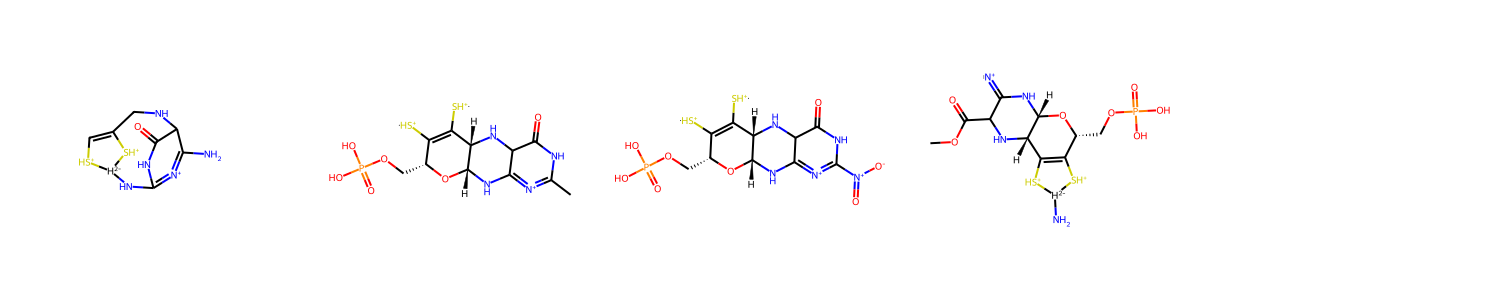

In [27]:
Draw.MolsToGridImage(derivative_mols, molsPerRow=5, subImgSize=(300,300))

Docking every generated derivative would quickly use up a lot of memory. The widget created by the cell below allows for both a single derivative and multiple derivatives to be docked. To select multiple derivatives, hold down the control key (PC) or command key (Mac) while clicking on the names of each derivative you would like to dock. The names of a given derivative corresponds to its location in the grid above (for example, `derivative_0` is at index 0 and is the first derivative shown in the grid)

In [11]:
style = {'description_width': 'initial'}
select_drop = SelectMultiple(options = derivs, description = 'Select Derivative/s to Dock:', style = style)
select_drop

SelectMultiple(description='Select Derivative/s to Dock:', options=('derivative_0', 'derivative_1', 'derivativ…

### Dock and Analyze Derivatives

The derivatives can be docked against the receptor using the same procedure used to dock the original ligands in the previous notebook (`docking-and-prelim-analysis`). The number of derivatives to be docked and the derivatives that will be used depends on the selection/s using the widget above. As the procedure is the same, the step-by-step guide for VINA and SMINA is identical to the one in `docking-and-prelim-analysis`.

#### Docking with Vina

Below is a step-by-step (cell-by-cell) guide on how the VINA docking engine is used to generate poses and scores for each pocket and ligand

- Prior to docking, two new folders are created in the data folder to organize the output data (vina_out and vina_out_2).
- Using the information collected in the docking-prep notebook, each pocket's center values and size values are added to their respective lists, which are called pocket_center and pocket_size. In both lists, each instance is a list of the x, y, and z values corresponding to one pocket's data (as a result, pocket_center and pocket_size are nested lists, and the length of both lists is equal to the number of binding pockets)
    - For example, pocket_center may look like this: [[x1, y1, z1][x2, y2, z2][x3, y3, z3]]
- Using the pocket size and center lists and the pdbqt files for the receptor and desired ligand, ligand poses are generated for each binding pocket (the number of poses depends on the value of n_poses, which is set to 5 in this notebook). The amount of computational effort needed to generate the poses for a given pocket and ligand is called the exhaustiveness. As exhaustiveness increases, the more reproducible the results tend to be. While the default value of exhaustiveness is 8, this notebook uses an exhaustiveness of 5 due to memory limitations.
- The results of running the VINA docking engine are stored as pdbqt files and can be located in the vina_out folder. In order to analyze and vizualize the results, the pdbqt files are converted into sdf files using the function pdbqt_to_sdf (created by Angel Ruiz-Moreno), which can be found in the vina_out_2 folder. The names of each file follows the formula of `(ligand name)_vina_pocket_(pocket number).pdbqt` for the pdbqt files and `(ligand name)_pocket_(pocket number)_(name of folder).sdf` for the sdf files.

In [12]:
from vina import Vina

current_dir = os.getcwd()
vina_out = os.path.join(current_dir, "data", "vina_out")
vina_out_2 = os.path.join(current_dir, "data", "vina_out_2")

pocket_center = []
pocket_size = []

for i in select_drop.value:
    for pocket in prot_pockets.index:
        c_x = prot_pockets.loc[pocket,'center_x']
        c_y = prot_pockets.loc[pocket,'center_y']
        c_z = prot_pockets.loc[pocket,'center_z']
        s_x = prot_pockets.loc[pocket,'size_x']
        s_y = prot_pockets.loc[pocket,'size_y']
        s_z = prot_pockets.loc[pocket,'size_z']
        pocket_center.append([c_x, c_y, c_z])
        pocket_size.append([s_x, s_y, s_z])

In [13]:
def vina_dock(ligand):
    v = Vina(sf_name='vina')
    v.set_receptor(f'data/PDBQT_files/{pdb_id}_protein.pdbqt')
    v.set_ligand_from_file(f"data/PDBQT_files/{ligand}.pdbqt")
    for pock_num, pocket in enumerate(prot_pockets.index):
        v.compute_vina_maps(center = pocket_center[pock_num], box_size = pocket_size[pock_num])
        v.dock(exhaustiveness=5, n_poses=5)
        v.write_poses("data/vina_out/" + str(ligand) + "_vina_pocket_" + str(pocket) + '.pdbqt', n_poses=5, overwrite=True)

In [14]:
for i in select_drop.value:
    vina_dock(i)

Computing Vina grid ... done.


Performing docking (random seed: -970257154) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -6.242          0          0
   2       -5.913      2.755      4.825
   3       -5.888      2.293      3.198
   4        -5.73      3.301      5.115
   5       -5.661      3.526      4.833
Computing Vina grid ... done.
Performing docking (random seed: -970257154) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************



mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -6.357          0          0
   2       -6.324       46.4      47.47
   3       -5.906      47.06      48.05
   4       -5.878      2.692      4.741
   5       -5.771      3.309      5.089
Computing Vina grid ... done.
Performing docking (random seed: -970257154) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -5.208          0          0
   2       -5.156       22.9      24.62
   3       -5.048       25.6      27.11
   4       -5.012      24.02      25.87
   5        -4.94      25.34         27
Computing Vina grid ... done.
Performing docking (random seed: -970257154) ... 
0%   10   20   30   40   50   60   


mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1        -5.25          0          0
   2       -4.963      2.861      4.318
   3       -4.936      30.11      31.66
   4         -4.9      32.27      33.27
   5       -4.794      2.012      3.918
Computing Vina grid ... done.
Performing docking (random seed: -970257154) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -5.525          0          0
   2        -5.24      11.12       11.9
   3       -5.194      2.664      4.566
   4       -4.808      3.093      5.235
   5        -4.52      11.86      12.65
Computing Vina grid ... done.
Performing docking (random seed: -970257154) ... 
0%   10   20   30   40   50   60   


mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1        -5.18          0          0
   2        -4.69       43.8      44.81
   3       -4.577      2.287      2.884
   4       -4.448      49.01       49.7
   5       -4.421      47.71      49.28
Computing Vina grid ... done.
Performing docking (random seed: -970257154) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -6.321          0          0
   2       -5.933      2.445      3.289
   3       -5.635      3.879      6.565
   4       -5.577      3.251       5.09
   5         -4.3      44.48       46.1
Computing Vina grid ... done.
Performing docking (random seed: -970257154) ... 
0%   10   20   30   40   50   60   

In [15]:
for i in select_drop.value:
    for pocket in prot_pockets.index:
            pdbqt_to_sdf(pdbqt_file= f"data/vina_out/{i}_vina_pocket_{pocket}.pdbqt",output= f"data/vina_out_2/{i}_pocket_{pocket}_vina_out_2.sdf")

#### Docking with Smina

Below is a step-by-step (cell-by-cell) guide on how the SMINA docking engine is used to generate poses and scores for each pocket and ligand
- Prior to docking, two new folders are created in the data folder to organize the output data (smina_out and smina_out_2). The path for the smina docking engine executable is also initialized to allow for the docking engine to be used, as it is a local file.
- Using the the pdbqt file for the receptor, the mol2 file for the desired ligand, and the pocket center/size values from the prot_pockets dataframe, ligand poses are generated for each binding pocket (the number of poses depends on the value of num_modes, which is set to 5 in this notebook). The amount of computational effort needed to generate the poses for a given pocket and ligand is called the exhaustiveness. As exhaustiveness increases, the more reproducible the results tend to be. While the default value of exhaustiveness is 8, this notebook uses an exhaustiveness of 5 due to memory limitations.
- The results of running the SMINA docking engine are stored as sdf files and can be located in the smina_out folder. However, due to the fact that the output files do not have a flag marking it as three dimensional, the sdf files must be read using SDMolSupplier and re-written using SDWriter to avoid excessive errors. The re-written sdf files can be found in the smina_out_2 folder. The names of each file follows the formula of `(ligand name)_pocket_(pocket number)_(name of folder).sdf` for the sdf files.

In [40]:
current_dir = os.getcwd()
smina_out = os.path.join(current_dir, "data", "smina_out")
smina_out_2 = os.path.join(current_dir, "data", "smina_out_2")

d = 0
for i in select_drop.value: 
    for pocket in prot_pockets.index:
        rec = f'data/PDBQT_files/{pdb_id}_protein.pdbqt'
        lig = f'data/MOL2_files/{i}_H.mol2'
        outfile = f'data/smina_out/{i}_pocket_{pocket}_smina_out.sdf'
        ! smina -r {rec} -l {lig} -o {outfile} --autobox_ligand {lig} --autobox_add 5 --exhaustiveness 5 --num_modes 5

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: -653099564

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------


***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -4.5       0.000      0.000    
2       -4.4       3.449      5.977    
3       -4.4       3.215      5.056    
4       -4.2       2.051      2.369    
5       -4.2       4.115      5.427    
Refine time 1.617
Loop time 1.960
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydropho

In [ ]:
# Rewrite .sdf output files to add 3D tag
# This code will result in warnings. This is normal as long as the warning is
# "Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D."
mols_all = []
for i in select_drop.value:
    mols = []
    for pocket in prot_pockets.index:
        with Chem.SDMolSupplier(f'data/smina_out/{i}_pocket_{pocket}_smina_out.sdf') as suppl:
            for mol in suppl:
                Chem.MolToMolBlock(mol)
                mols.append(mol)
            mols_all.append(mols)

a = 0
for i in select_drop.value:
    for pocket in prot_pockets.index:
        with Chem.SDWriter(f"data/smina_out_2/{i}_pocket_{pocket}_smina_out_2.sdf") as w:
            for mol in mols_all[a]:
                w.write(mol)
            a += 1

## Analysis of derivative docking output

Now that we have results from molecular docking, we need to make sense of the information. If you were to open the sdf files in a text editor, you would see x, y, and z coordinates for each atom in the ligand, the bond types between atoms in the ligand, and the score of the ligand pose. While useful, this information is difficult to interpret and visualize. To get information regarding the number of interactions, the types of interaction, and the atoms (ligand) and residues (receptor) involved in binding the ligand to the receptor, interaction fingerprints (IFPs) can be generated and viewed using the prolif library, which can be used to identify key atoms in the ligand and key residues in the receptor involved in protein-ligand complex formation.

In [12]:
style = {'description_width': 'initial'}
select_dock = Dropdown(options = ["smina", "vina"], description = 'Select Docking Engine:', style = style)
select_dock

Dropdown(description='Select Docking Engine:', options=('smina', 'vina'), style=DescriptionStyle(description_w…

(get scores for all results)

In [13]:
all_results = []
scores = [] # get list of scores for each pose
for h, i in enumerate(select_drop.value):
    # initialize list that contains values all poses in all pockets (for 1 ligand at a time)
    nested_results = []
    # append pose data for each pocket to nested_results
    for pocket in prot_pockets.index:
        results = Chem.SDMolSupplier(f"data/{select_dock.value}_out_2/{i}_pocket_{pocket}_{select_dock.value}_out_2.sdf")
        nested_results.append(results) 
    # add all values in nested_results to allResults list
    all_results.append(nested_results)
    
# get score values for every pose in allResults
for linenum, i in enumerate(all_results):
    for num, pocket in enumerate(i):
        for num2, pose in enumerate(pocket):
            if select_dock.value == "smina":
                scores.append(float(all_results[linenum][num][num2].GetProp('minimizedAffinity')))
            else:
                scores.append(float(all_results[linenum][num][num2].GetProp('Score')))

(Get interactions for derivatives)

In [14]:
prot_mol = Chem.MolFromPDBFile("data/PDB_files/" + str(pdb_id) + "_protein_H.pdb")
protein_plf = plf.Molecule.from_rdkit(prot_mol)

In [15]:
all_ligand_plf = []
ligand_plf = []
all_df = []
all_ifps = []
for i in select_drop.value:
        for pocket in prot_pockets.index:
            lig_suppl = plf.sdf_supplier(f"data/{select_dock.value}_out_2/{i}_pocket_{pocket}_{select_dock.value}_out_2.sdf")
            fp = plf.Fingerprint(count=True)
            fp.run_from_iterable(lig_suppl, protein_plf)
            results_df = fp.to_dataframe()
            all_df.append(results_df)
            for lig in lig_suppl:
                all_ligand_plf.append(lig)
                ifp = fp.generate(lig, protein_plf, metadata = True)
                all_ifps.append(ifp)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [31]:
df = pd.concat([d for d in all_df], axis=0, ignore_index=False, sort=False, keys = prot_pockets.index).reset_index()
df.insert(2, "Score", pd.Series(scores))
df = df.fillna(0)
df

ligand      cav_id Frame  Score        UNL1                                   \
protein                            PHE798.L   MET1038.L  GLN1040.L THR1077.L   
interaction                     Hydrophobic Hydrophobic VdWContact   HBDonor   
0                1     0 -6.242         0.0         0.0        1.0       0.0   
1                1     1 -5.913         0.0         0.0        0.0       0.0   
2                1     2 -5.888         0.0         0.0        1.0       1.0   
3                1     3 -5.730         0.0         0.0        1.0       0.0   
4                1     4 -5.661         2.0         1.0        0.0       0.0   
5                2     0 -6.357         0.0         0.0        0.0       0.0   
6                2     1 -6.324         0.0         0.0        2.0       0.0   
7                2     2 -5.906         0.0         0.0        0.0       1.0   
8                2     3 -5.878         0.0         0.0        0.0       0.0   
9                2     4 -5.771         0.0         0.0        0.0       0.0   
10               3     0 -5.208         0.0         0.0        0.0       0.0   
11               3     1 -5.156         0.0         0.0        0.0       0.0   
12               3     2 -5.048         0.0         0.0        0.0       0.0   
13               3     3 -5.012         0.0         0.0        0.0       0.0   
14               3     4 -4.940         0.0         0.0        0.0       0.0   
15               5     0 -5.599         0.0         0.0        0.0       0.0   
16               5     1 -5.426         0.0         0.0        0.0       0.0   
17               5     2 -4.966         0.0         0.0        0.0       0.0   
18               5     3 -4.085         0.0         0.0        0.0       0.0   
19               5     4 -4.039         0.0         0.0        0.0       0.0   
20              30     0 -5.250         0.0         0.0        0.0       0.0   
21              30     1 -4.963         0.0         0.0        0.0       0.0   
22              30     2 -4.936         0.0         0.0        0.0       0.0   
23              30     3 -4.900         0.0         0.0        0.0       0.0   
24              30     4 -4.794         0.0         0.0        0.0       0.0   
25              55     0 -5.525         0.0         0.0        0.0       0.0   
26              55     1 -5.240         0.0         0.0        0.0       0.0   
27              55     2 -5.194         0.0         0.0        0.0       0.0   
28              55     3 -4.808         0.0         0.0        0.0       0.0   
29              55     4 -4.520         0.0         0.0        0.0       0.0   
30             102     0 -6.375         0.0         0.0        0.0       0.0   
31             102     1 -5.688         0.0         0.0        0.0       0.0   
32             102     2 -5.602         0.0         0.0        0.0       0.0   
33             102     3 -5.265         0.0         0.0        0.0       0.0   
34             102     4 -4.432         0.0         0.0        0.0       0.0   
35             106     0 -5.180         0.0         0.0        0.0       0.0   
36             106     1 -4.690         0.0         0.0        0.0       0.0   
37             106     2 -4.577         0.0         0.0        0.0       0.0   
38             106     3 -4.448         0.0         0.0        0.0       0.0   
39             106     4 -4.421         0.0         0.0        0.0       0.0   
40             131     0 -6.321         0.0         0.0        0.0       0.0   
41             131     1 -5.933         0.0         0.0        0.0       0.0   
42             131     2 -5.635         0.0         0.0        0.0       0.0   
43             131     3 -5.577         0.0         0.0        0.0       0.0   
44             131     4 -4.300         0.0         0.0        0.0       0.0   
45             152     0 -5.155         0.0         0.0        0.0       0.0   
46             152     1 -5.114         0.0         0.0        0.0       0.0   


While the dataframe generated using the prolif library has a lot of useful information, we are also going to add the distance between interacting ligand and protein atoms, the indexes of both the ligand and protein atoms involved in the interaction, and the functional group the ligand's atom is a member of if applicable.

In [17]:
df2 = df[["cav_id", "Frame", "Score"]].copy()

ligand,cav_id,Frame,Score
protein,,,
interaction,,,
0,1,0,-6.242
1,1,1,-5.913
2,1,2,-5.888
3,1,3,-5.730
4,1,4,-5.661
5,2,0,-6.357
6,2,1,-6.324
7,2,2,-5.906


In [18]:
col_names_list = []
residues = []
interactions = []
for key in all_ifps:
    for key_new in key:
        for key_2 in key[key_new]:
            residues.append(str(key_new[1]))
            interactions.append(str(key_2))
            lig_name = str(key_new[0])
            res_name = str(key_new[1])
            column_name = (lig_name, res_name, key_2)
            if column_name not in col_names_list:
                col_names_list.append(column_name)
                new_col_0 = (lig_name, res_name, f"Functional group involved ({key_2})")
                new_col_1 = (lig_name, res_name, f"Distance ({key_2})")
                new_col_2 = (lig_name, res_name, f"Index 1 (Ligand) ({key_2})")
                new_col_3 = (lig_name, res_name, f"Index 2 (Ligand) ({key_2})")
                new_col_4 = (lig_name, res_name, f"Index 3 (Protein) ({key_2})")
                new_col_5 = (lig_name, res_name, f"Index 4 (Protein) ({key_2})")
                df2[column_name] = df[column_name]
                df2[new_col_0] = pd.Series([0] * df.shape[0])
                df2[new_col_1] = pd.Series([0] * df.shape[0])
                df2[new_col_2] = pd.Series([0] * df.shape[0])
                df2[new_col_3] = pd.Series([0] * df.shape[0])
                df2[new_col_4] = pd.Series([0] * df.shape[0])
                df2[new_col_5] = pd.Series([0] * df.shape[0])

/var/folders/g5/5p5jghhd0x15dj8v2h4c3np00000gn/T/ipykernel_76364/3962807831.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[column_name] = df[column_name]
/var/folders/g5/5p5jghhd0x15dj8v2h4c3np00000gn/T/ipykernel_76364/3962807831.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[new_col_0] = pd.Series([0] * df.shape[0])
/var/folders/g5/5p5jghhd0x15dj8v2h4c3np00000gn/T/ipykernel_76364/3962807831.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

ligand      cav_id Frame  Score      UNL1                                      \
protein                         THR1083.L                                       
interaction                       HBDonor Functional group involved (HBDonor)   
0                1     0 -6.242       1.0                                   0   
1                1     1 -5.913       0.0                                   0   
2                1     2 -5.888       0.0                                   0   
3                1     3 -5.730       0.0                                   0   
4                1     4 -5.661       0.0                                   0   
5                2     0 -6.357       0.0                                   0   
6                2     1 -6.324       1.0                                   0   
7                2     2 -5.906       0.0                                   0   
8                2     3 -5.878       0.0                                   0   
9                2     4 -5.771       0.0                                   0   
10               3     0 -5.208       0.0                                   0   
11               3     1 -5.156       0.0                                   0   
12               3     2 -5.048       0.0                                   0   
13               3     3 -5.012       0.0                                   0   
14               3     4 -4.940       0.0                                   0   
15               5     0 -5.599       0.0                                   0   
16               5     1 -5.426       0.0                                   0   
17               5     2 -4.966       0.0                                   0   
18               5     3 -4.085       0.0                                   0   
19               5     4 -4.039       0.0                                   0   
20              30     0 -5.250       0.0                                   0   
21              30     1 -4.963       0.0                                   0   
22              30     2 -4.936       0.0                                   0   
23              30     3 -4.900       0.0                                   0   
24              30     4 -4.794       0.0                                   0   
25              55     0 -5.525       0.0                                   0   
26              55     1 -5.240       0.0                                   0   
27              55     2 -5.194       0.0                                   0   
28              55     3 -4.808       0.0                                   0   
29              55     4 -4.520       0.0                                   0   
30             102     0 -6.375       0.0                                   0   
31             102     1 -5.688       0.0                                   0   
32             102     2 -5.602       0.0                                   0   
33             102     3 -5.265       0.0                                   0   
34             102     4 -4.432       0.0                                   0   
35             106     0 -5.180       0.0                                   0   
36             106     1 -4.690       0.0                                   0   
37             106     2 -4.577       0.0                                   0   
38             106     3 -4.448       0.0                                   0   
39             106     4 -4.421       0.0                                   0   
40             131     0 -6.321       0.0                                   0   
41             131     1 -5.933       0.0                                   0   
42             131     2 -5.635       0.0                                   0   
43             131     3 -5.577       0.0                                   0   
44             131     4 -4.300       0.0                                   0   
45             152     0 -5.155       0.0                                   0   
46             152     1 -5.114

In [19]:
df2 = df2.astype(object)

In [20]:
for number, key in enumerate(all_ifps):
    for key_new in key:
        for key_2 in key[key_new]:
            lig_name = str(key_new[0])
            res_name = str(key_new[1])
            column_name = (lig_name, res_name, key_2)
            new_col_0 = (lig_name, res_name, f"Functional group involved ({key_2})")
            new_col_1 = (lig_name, res_name, f"Distance ({key_2})")
            new_col_2 = (lig_name, res_name, f"Index 1 (Ligand) ({key_2})")
            new_col_3 = (lig_name, res_name, f"Index 2 (Ligand) ({key_2})")
            new_col_4 = (lig_name, res_name, f"Index 3 (Protein) ({key_2})")
            new_col_5 = (lig_name, res_name, f"Index 4 (Protein) ({key_2})")
            get_pose = df2["Frame"][number]
            x = key[key_new]
            y = x[key_2]
            df_groups = []
            df_distance = []
            df_ind_1 = []
            df_ind_2 = []
            df_ind_3 = []
            df_ind_4 = []
            for inst_num, instance in enumerate(y):
                distance = instance["distance"]
                df_distance.append(distance)
                parent_index = instance["parent_indices"]
                if len(parent_index["ligand"]) == 2:
                    df_ind_1.append(parent_index["ligand"][0])
                    df_ind_2.append(parent_index["ligand"][1])
                else:
                    df_ind_1.append(parent_index["ligand"][0])
                    df_ind_2.append(0)
                if len(parent_index["protein"]) == 2:
                    df_ind_3.append(parent_index["protein"][0])
                    df_ind_4.append(parent_index["protein"][1])
                else:
                    df_ind_3.append(parent_index["protein"][0])
                    df_ind_4.append(0)
                current = all_ligand_plf[number]
                group_ints = group_idxes_from_mol(current)
                for value in group_ints.keys():
                    if len(parent_index["ligand"]) == 2:
                        if value == parent_index["ligand"][0] | value == parent_index["ligand"][1]:
                            df_groups.append(int(groups_to_numbers[group_ints[value]]))
                    else:
                        if value == parent_index["ligand"][0]:
                            df_groups.append(int(groups_to_numbers[group_ints[value]]))
                if len(df_groups) == inst_num:
                    df_groups.append(0)
            df2.at[number, new_col_0] = df_groups
            df2.at[number, new_col_1] = df_distance
            df2.at[number, new_col_2] = df_ind_1
            df2.at[number, new_col_3] = df_ind_2
            df2.at[number, new_col_4] = df_ind_3
            df2.at[number, new_col_5] = df_ind_4

In [22]:
df2.to_csv('data/deriv_information.csv', index = False)
df2

ligand      cav_id Frame  Score      UNL1                                      \
protein                         THR1083.L                                       
interaction                       HBDonor Functional group involved (HBDonor)   
0                1     0 -6.242       1.0                                 [0]   
1                1     1 -5.913       0.0                                   0   
2                1     2 -5.888       0.0                                   0   
3                1     3  -5.73       0.0                                   0   
4                1     4 -5.661       0.0                                   0   
5                2     0 -6.357       0.0                                   0   
6                2     1 -6.324       1.0                                 [0]   
7                2     2 -5.906       0.0                                   0   
8                2     3 -5.878       0.0                                   0   
9                2     4 -5.771       0.0                                   0   
10               3     0 -5.208       0.0                                   0   
11               3     1 -5.156       0.0                                   0   
12               3     2 -5.048       0.0                                   0   
13               3     3 -5.012       0.0                                   0   
14               3     4  -4.94       0.0                                   0   
15               5     0 -5.599       0.0                                   0   
16               5     1 -5.426       0.0                                   0   
17               5     2 -4.966       0.0                                   0   
18               5     3 -4.085       0.0                                   0   
19               5     4 -4.039       0.0                                   0   
20              30     0  -5.25       0.0                                   0   
21              30     1 -4.963       0.0                                   0   
22              30     2 -4.936       0.0                                   0   
23              30     3   -4.9       0.0                                   0   
24              30     4 -4.794       0.0                                   0   
25              55     0 -5.525       0.0                                   0   
26              55     1  -5.24       0.0                                   0   
27              55     2 -5.194       0.0                                   0   
28              55     3 -4.808       0.0                                   0   
29              55     4  -4.52       0.0                                   0   
30             102     0 -6.375       0.0                                   0   
31             102     1 -5.688       0.0                                   0   
32             102     2 -5.602       0.0                                   0   
33             102     3 -5.265       0.0                                   0   
34             102     4 -4.432       0.0                                   0   
35             106     0  -5.18       0.0                                   0   
36             106     1  -4.69       0.0                                   0   
37             106     2 -4.577       0.0                                   0   
38             106     3 -4.448       0.0                                   0   
39             106     4 -4.421       0.0                                   0   
40             131     0 -6.321       0.0                                   0   
41             131     1 -5.933       0.0                                   0   
42             131     2 -5.635       0.0                                   0   
43             131     3 -5.577       0.0                                   0   
44             131     4   -4.3       0.0                                   0   
45             152     0 -5.155       0.0                                   0   
46             152     1 -5.114

### Title here

Using an IFP, the interactions between the ligand and the receptor can be visualized using prolif's Complex3D submodule. Only one pose and its interactions can be viewed at a time.

In [310]:
# display interactions. select which one to view using dropdown
pose_pock_select = []
a = 0
while a < int(df.shape[0]):
    pose_pock_select.append(a + 1)
    a += 1
style = {'description_width': 'initial'}
select_pose = Dropdown(options = pose_pock_select, description = 'Select Pose to View:', style = style)
select_pose

Dropdown(description='Select Pose to View:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1…

In [312]:
comp = Complex3D(all_ifps[select_pose.value], all_ligand_plf[select_pose.value], protein_plf)
comp.display()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Title

In [ ]:
# Make dictionary of residues and residue type, where 1 = hydrophobic alipathic, 2 = hydrophobic aromatic, 
# 3 = polar uncharged, 4 = polar acidic, and 5 = polar basic
type_dict = {
    'GLY': 1,
    'ALA': 1,
    'VAL': 1,
    'LEU': 1,
    'ILE': 1,
    'PRO': 1,
    'MET': 1,
    'PHE': 2,
    'TYR': 2,
    'TRP': 2,
    'SER': 3,
    'THR': 3,
    'CYS': 3,
    'ASN': 3,
    'GLN': 3,
    'ASP': 4,
    'GLU': 4,
    'ARG': 5,
    'HIS': 5,
    'LYS': 5
}
# Make dictionary of possible protein-ligand interactions and assign a number based on the interaction present
int_dict = {
    "Hydrophobic": 1,
    "HBAcceptor": 2,
    "HBDonor": 3,
    "XBAcceptor": 4,
    "XBDonor": 5,
    "Cationic": 6,
    "Anionic": 7,
    "CationPi": 8,
    "PiCation": 9,
    "FaceToFace": 10,
    "EdgeToFace": 11,
    "PiStacking": 12,
    "MetalDonor": 13,
    "MetalAcceptor": 14,
    "VdWContact": 15
}

residue_num = [] # the number of the residue in each interaction
residue_type = [] # the type of the residue in each interaction (as a number)
interactions_num = [] # the type of interaction in each interaction (as a number)

for i in residues:
    number_found = re.findall(r'\d+', i)
    residue_num.append(int(number_found[0]))
    type_found = i[:3]
    residue_type.append(type_dict[type_found])
for i in interactions:
    interactions_num.append(int(int_dict[i]))
